In [126]:
# Checking GPU
import torch
print("Torch:", torch.__version__)
print("Built with CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("Compute capability:", torch.cuda.get_device_capability(0))

Torch: 2.10.0.dev20251016+cu128
Built with CUDA: 12.8
CUDA available: True
GPU: NVIDIA GeForce RTX 5050 Laptop GPU
Compute capability: (12, 0)


In [127]:
#Importing libraries and setting device
import torch
import os   
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
import os

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [128]:
fn = 'JPM_SAMPLE_DATA_ONE.csv'

# read raw; header=None avoids pandas treating first row as header
df_raw = pd.read_csv(fn, sep=';', decimal=',', engine='python')

if df_raw.shape[1] == 1:
    s = df_raw.iloc[:, 0].astype(str)
    # detect delimiter in the string column and split accordingly
    if s.str.contains(',').any():
        parts = s.str.split(',', expand=True)
    else:
        parts = s.str.split(r'\s+', expand=True)
    X = parts.astype(float).values  # shape: (n_rows, n_pixels)
else:
    # already multi-column numeric
    X = df_raw.values.astype(float)

# read labels (adjust sep/decimal/header if needed)
y = pd.read_csv('JPM_LABELS_ONE.csv', sep=';', decimal=',', engine='python').values.flatten()

print('X.shape =', X.shape)
print('y.shape =', y.shape)


X.shape = (4182, 113)
y.shape = (4182,)


In [129]:
BATCH_SIZE = 64

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=RANDOM_SEED)

from torch.utils.data import DataLoader

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(X_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,          
    shuffle=True,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=1024,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1024,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
) 

In [130]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_hidden_3, num_hidden_4, num_hidden_5, num_hidden_6, num_targets=1):
        super(MLP, self).__init__()
        
        ### ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1,bias=True)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2,bias=True)
        self.linear_3 = torch.nn.Linear(num_hidden_2, num_hidden_3,bias=True)
        self.linear_4 = torch.nn.Linear(num_hidden_3, num_hidden_4,bias=True)
        self.linear_5 = torch.nn.Linear(num_hidden_4, num_hidden_5,bias=True)
        self.linear_6 = torch.nn.Linear(num_hidden_5, num_hidden_6,bias=True)
        self.linear_out = torch.nn.Linear(num_hidden_6,  num_targets) 
        
    def forward(self, x):
        
        ### MAKE SURE YOU CONNECT THE LAYERS PROPERLY IF YOU CHANGED
        ### ANYTHNG IN THE __init__ METHOD ABOVE       
        out = F.gelu(self.linear_1(x))
        out = F.dropout(out, p=0.2)
        out = F.gelu(self.linear_2(out))
        out = F.dropout(out, p=0.2)
        out = F.gelu(self.linear_3(out))
        out = F.dropout(out, p=0.2)
        out = F.gelu(self.linear_4(out))
        out = F.dropout(out, p=0.2)
        out = F.gelu(self.linear_5(out))
        out = F.dropout(out, p=0.2)
        out = F.gelu(self.linear_6(out))
        logits = self.linear_out(out)
        preds = self.linear_out(out)   # <-- no softmax for regression
        return preds

    
#################################
### Model Initialization
#################################


# the random seed makes sure that the random weight initialization
# in the model is always the same.
# In practice, some weights don't work well, and we may also want
# to try different random seeds. In this homework, this is not
# necessary.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU 
### ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you
### added a second hidden layer, you may want to add a
### hidden_2 parameter here. Also you may want to play
### with the number of hidden units.

model = MLP(
    num_features=113,
    num_hidden_1=1000,
    num_hidden_2=512,
    num_hidden_3=256,
    num_hidden_4=128,
    num_hidden_5=64,
    num_hidden_6=32,
    num_targets=1   # or y.shape[1] if multi-target
).to(DEVICE)

In [131]:
import time, torch
import torch.nn.functional as F

# ---- Hyperparams safer for regression with unnormalized data ----
LR = 1e-4                # lower LR to avoid blow-ups
CLIP_NORM = 1.0          # gradient clipping
USE_HUBER = False        # switch to True if you have outliers

criterion = torch.nn.SmoothL1Loss() if USE_HUBER else torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
NUM_EPOCHS = 100

# ---- Compute target mean/std on the TRAIN set (for stability) ----
# We only standardize y; images (if any) are scaled to [0,1] per batch.
with torch.no_grad():
    y_sum, y_sumsq, y_count = 0.0, 0.0, 0
    for feats, targ in train_loader:
        targ = targ.float()
        if targ.ndim == 1:
            targ = targ.unsqueeze(1)
        y_sum   += targ.sum().item()
        y_sumsq += (targ ** 2).sum().item()
        y_count += targ.numel()
    y_mean = y_sum / max(y_count, 1)
    y_var  = max(y_sumsq / max(y_count, 1) - y_mean**2, 1e-12)
    y_std  = y_var ** 0.5

def standardize_y(y):
    y = y.float()
    if y.ndim == 1:
        y = y.unsqueeze(1)
    return (y - y_mean) / y_std

def unstandardize_y(y_hat):
    return y_hat * y_std + y_mean

def prepare_features(x):
    # Cast to float32 and flatten images; scale images to [0,1]
    if x.ndim > 2:
        x = x.view(x.size(0), -1)
        x = x.float() / 255.0
    else:
        x = x.float()
    return x

# ---- Safe eval: RMSE/MAE/R2 on ORIGINAL target scale ----
def compute_metrics_and_loss(model, data_loader, device):
    model.eval()
    sse = sae = 0.0
    n_elems = 0
    sum_y = sum_y2 = 0.0
    with torch.no_grad():
        for feats, targ in data_loader:
            feats = prepare_features(feats).to(device)
            targ_std = standardize_y(targ).to(device)     # model trains in standardized y
            preds_std = model(feats)
            # sanity checks
            if not torch.isfinite(preds_std).all() or not torch.isfinite(targ_std).all():
                raise RuntimeError("Non-finite values during eval.")
            # convert both to original scale for metrics
            preds = unstandardize_y(preds_std).cpu()
            targ  = targ_std.cpu() * y_std + y_mean
            # accumulate
            sse += F.mse_loss(preds, targ, reduction='sum').item()
            sae += F.l1_loss(preds,  targ, reduction='sum').item()
            n_elems += targ.numel()
            sum_y  += targ.sum().item()
            sum_y2 += (targ**2).sum().item()

    mse = sse / max(n_elems, 1)
    rmse = mse ** 0.5
    mae = sae / max(n_elems, 1)
    sst = max(sum_y2 - (sum_y * sum_y) / max(n_elems, 1), 1e-12)
    r2 = 1.0 - (sse / sst)
    return rmse, mae, r2, mse

# --------------------- Training Loop (safer) ---------------------
start_time = time.time()
train_rmse_lst, valid_rmse_lst = [], []
train_mae_lst,  valid_mae_lst  = [], []
train_r2_lst,   valid_r2_lst   = [], []
train_mse_lst,  valid_mse_lst  = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = prepare_features(features).to(DEVICE)
        targets_std = standardize_y(targets).to(DEVICE)

        preds_std = model(features)

        # Assert finiteness early (helps catch bad batches/data)
        if not (torch.isfinite(features).all() and torch.isfinite(targets_std).all() and torch.isfinite(preds_std).all()):
            # print quick diagnostics
            print("Non-finite encountered.")
            print("features stats:", features.min().item(), features.max().item())
            print("targets_std stats:", targets_std.min().item(), targets_std.max().item())
            raise RuntimeError("Aborting due to NaN/Inf.")

        cost = criterion(preds_std, targets_std)
        optimizer.zero_grad(set_to_none=True)
        cost.backward()

        # Clip gradients to prevent exploding updates
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)

        optimizer.step()

        if not batch_idx % 20:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                  f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                  f'MSE(std y): {cost.item():.6f}')

    with torch.no_grad():
        tr_rmse, tr_mae, tr_r2, tr_mse = compute_metrics_and_loss(model, train_loader, device=DEVICE)
        va_rmse, va_mae, va_r2, va_mse = compute_metrics_and_loss(model, valid_loader, device=DEVICE)

        train_rmse_lst.append(tr_rmse); valid_rmse_lst.append(va_rmse)
        train_mae_lst.append(tr_mae);   valid_mae_lst.append(va_mae)
        train_r2_lst.append(tr_r2);     valid_r2_lst.append(va_r2)
        train_mse_lst.append(tr_mse);   valid_mse_lst.append(va_mse)

        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
              f'Train RMSE: {tr_rmse:.4f} | Val RMSE: {va_rmse:.4f} | '
              f'Train R^2: {tr_r2:.4f} | Val R^2: {va_r2:.4f}')

    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')


Epoch: 001/100 | Batch 000/052 | MSE(std y): 28764300.000000
Epoch: 001/100 | Batch 020/052 | MSE(std y): 3979698.250000
Epoch: 001/100 | Batch 040/052 | MSE(std y): 3831237.500000
Epoch: 001/100 Train RMSE: 3440.7414 | Val RMSE: 4078.4848 | Train R^2: -2825429.7629 | Val R^2: -4909898.2197
Time elapsed: 0.04 min
Epoch: 002/100 | Batch 000/052 | MSE(std y): 2407279.250000
Epoch: 002/100 | Batch 020/052 | MSE(std y): 1866262.375000
Epoch: 002/100 | Batch 040/052 | MSE(std y): 989555.750000
Epoch: 002/100 Train RMSE: 1802.3443 | Val RMSE: 1609.3262 | Train R^2: -763917.8102 | Val R^2: -764473.5776
Time elapsed: 0.05 min
Epoch: 003/100 | Batch 000/052 | MSE(std y): 625215.125000
Epoch: 003/100 | Batch 020/052 | MSE(std y): 545053.562500
Epoch: 003/100 | Batch 040/052 | MSE(std y): 361173.375000
Epoch: 003/100 Train RMSE: 1034.8980 | Val RMSE: 948.6489 | Train R^2: -252326.4771 | Val R^2: -265634.3520
Time elapsed: 0.05 min
Epoch: 004/100 | Batch 000/052 | MSE(std y): 119179.195312
Epoch: 

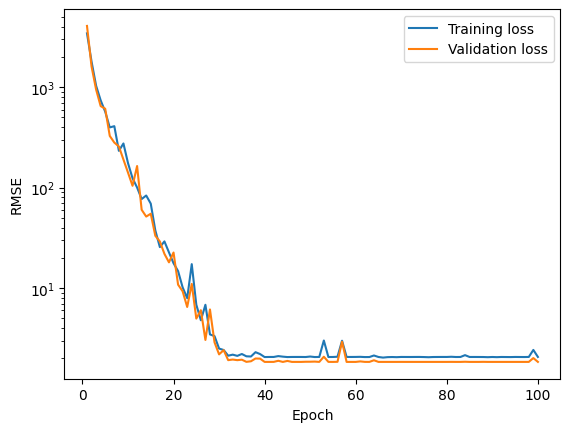

In [134]:
plt.plot(range(1, NUM_EPOCHS+1), train_rmse_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_rmse_lst, label='Validation loss')
plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

In [133]:
model.eval()
with torch.no_grad():  # disables gradient tracking for efficiency
    test_rmse, test_mae, test_r2, test_mse = compute_metrics_and_loss(model, test_loader, device=DEVICE)
    print(f'Test RMSE: {test_rmse:.4f} | Test MAE: {test_mae:.4f} | Test R²: {test_r2:.4f}')


Test RMSE: 1.6175 | Test MAE: 0.8828 | Test R²: -0.0001
